# Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import re
import ast
import sys
import cv2
import random
import json

!pip install num2words

from jiwer import wer

## CSF
proj_data_dir = "../../proj_data/"
proj_model_dir = "../../proj_models/"



## Personal
# proj_data_dir = "D:/USB/data_gen_6/"


proj_code_dir = "../classes"
sys.path.append(proj_code_dir)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, LSTM, TimeDistributed,Bidirectional, InputLayer,Attention,Dense,Dropout,Input,Embedding,MultiHeadAttention,LayerNormalization, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

!pip install datasets
from datasets import Dataset

2024-02-19 12:57:49.158684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 12:57:50.308033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/iusers01/fse-ugpgt01/compsci01/h61781jp/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [3]:
train_X_frames = []
train_X_landmarks = []
train_Y = []


test_X_frames = []
test_X_landmarks = []
test_Y = []

val_X_frames = []
val_X_landmarks = []
val_Y = []

In [4]:
for i in range(3):
    data_mat = loadmat(os.path.join(proj_data_dir, f"batches_both/split_large_{(i + 1)}.mat"))
    
    train_X_frames.extend(data_mat["train_data_frames"])
    train_X_landmarks.extend(data_mat["train_data_keypoints"])
    train_Y.extend(data_mat["train_labels"])

    test_X_frames.extend(data_mat["test_data_frames"])
    test_X_landmarks.extend(data_mat["test_data_keypoints"])
    test_Y.extend(data_mat["test_labels"])

    val_X_frames.extend(data_mat["val_data_frames"])
    val_X_landmarks.extend(data_mat["val_data_keypoints"])
    val_Y.extend(data_mat["val_labels"])

In [5]:
def show_data():
    print(f"Train data frames length: {np.shape(train_X_frames)}")
    print(f"Train data landmarks length: {np.shape(train_X_landmarks)}")
    print(f"Train labels length: {np.shape(train_Y)}")

    print(f"Test data frames length: {np.shape(test_X_frames)}")
    print(f"Test data landmarks length: {np.shape(test_X_landmarks)}")
    print(f"Test labels length: {np.shape(test_Y)}")

    print(f"Validation data frames length: {np.shape(val_X_frames)}")
    print(f"Validation data landmarks length: {np.shape(val_X_landmarks)}")
    print(f"Validation labels length: {np.shape(val_Y)}")

In [6]:
show_data()

Train data frames length: (26112, 29, 100, 100)
Train data landmarks length: (26112, 29, 40, 3)
Train labels length: (26112,)
Test data frames length: (3264, 29, 100, 100)
Test data landmarks length: (3264, 29, 40, 3)
Test labels length: (3264,)
Validation data frames length: (3264, 29, 100, 100)
Validation data landmarks length: (3264, 29, 40, 3)
Validation labels length: (3264,)


In [7]:
prune_begin = 4
prune_end = 4

In [8]:
def prune_data(data, before: int, after: int):
    new_data = []
    for batch in data:
        batch_length = len(batch)
        new_data.append(batch[before:(batch_length-after)])
    print(np.shape(new_data))
    return new_data

In [9]:
train_X_frames = prune_data(data=train_X_frames, before=prune_begin, after=prune_end)
test_X_frames = prune_data(data=test_X_frames, before=prune_begin, after=prune_end)
val_X_frames = prune_data(data=val_X_frames, before=prune_begin, after=prune_end)

train_X_landmarks = prune_data(data=train_X_landmarks, before=prune_begin, after=prune_end)
test_X_landmarks = prune_data(data=test_X_landmarks, before=prune_begin, after=prune_end)
val_X_landmarks = prune_data(data=val_X_landmarks, before=prune_begin, after=prune_end)

(26112, 21, 100, 100)
(3264, 21, 100, 100)
(3264, 21, 100, 100)
(26112, 21, 40, 3)
(3264, 21, 40, 3)
(3264, 21, 40, 3)


In [10]:
show_data()

Train data frames length: (26112, 21, 100, 100)
Train data landmarks length: (26112, 21, 40, 3)
Train labels length: (26112,)
Test data frames length: (3264, 21, 100, 100)
Test data landmarks length: (3264, 21, 40, 3)
Test labels length: (3264,)
Validation data frames length: (3264, 21, 100, 100)
Validation data landmarks length: (3264, 21, 40, 3)
Validation labels length: (3264,)


## Augment Data

In [11]:
import math

def rotate(x: float,y: float,z: float,theta: float,xo: float = 0.0,yo: float = 0.0):
    """
    Rotates an (x.y) about the origin specified by some theta
    """
    x_temp = x - xo
    y_temp = y - yo
    xr=math.cos(theta)*(x_temp)-math.sin(theta)*(y_temp)
    yr=math.sin(theta)*(x_temp)+math.cos(theta)*(y_temp)
    xr = xr + xo
    yr = yr + yo
    return [xr,yr,z]

def rotate_landmarks(landmarks, theta: float):
    new_landmarks = []
    for ldmk in landmarks:
        new_ldmk = rotate(x=ldmk[0],y=ldmk[1],z=ldmk[2],theta=theta, xo=0.5, yo=0.5)
        new_landmarks.append(new_ldmk)
    return new_landmarks

In [12]:
def augment_data_ldmk(data, labels, rotate = False):
  new_data = []
  new_labels = []
  for frames, label in zip(data, labels):
    aug_vector = [[1,0,0] for _ in range(40)]
    frames_flip = [np.abs(frame - aug_vector) for frame in frames]
    ##Gets a random rotation. Makes sure this isn't too small of a rotation
    if(rotate):
      random_theta = 0.0
      while(-0.1 <= random_theta <= 0.1):
        random_theta = random.uniform(-math.pi/4, math.pi/4)
      frames_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames]
      frames_flip_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames_flip]

    new_data.append(np.array(frames))
    new_data.append(np.array(frames_flip))
    if(rotate):
      new_data.append(np.array(frames_rotated))
      new_data.append(np.array(frames_flip_rotated))

    if(rotate):
      new_labels += ([label] * 4)
    else:
      new_labels += ([label] * 2)
  return (new_data, new_labels)

def augment_data_frames(data, labels):
  new_data = []
  new_labels = []
  for frames, label in zip(data, labels):
    new_frames = [cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB) for frame in frames]
    frames_flip = [cv2.flip(frame, 1) for frame in new_frames]

    new_data.append(np.array(new_frames))
    new_data.append(np.array(frames_flip))

    new_labels += ([label] * 2)
  return (new_data, new_labels)

In [13]:
train_X_frames, _ = augment_data_frames(data=train_X_frames, labels=train_Y)
test_X_frames, _ = augment_data_frames(data=test_X_frames, labels=test_Y)
val_X_frames, _ = augment_data_frames(data=val_X_frames, labels=val_Y)

train_X_landmarks, train_Y = augment_data_ldmk(data=train_X_landmarks, labels=train_Y)
test_X_landmarks, test_Y = augment_data_ldmk(data=test_X_landmarks, labels=test_Y)
val_X_landmarks, val_Y = augment_data_ldmk(data=val_X_landmarks, labels=val_Y)

In [14]:
show_data()

Train data frames length: (52224, 21, 100, 100, 3)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224,)
Test data frames length: (6528, 21, 100, 100, 3)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528,)
Validation data frames length: (6528, 21, 100, 100, 3)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528,)


## Convert Frames to FVs

In [15]:
def build_feature_extractor(img_shape: int = 100):
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(img_shape, img_shape,3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((img_shape, img_shape,3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

2024-02-19 13:05:04.560608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78945 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [16]:
frame_num = np.shape(train_X_frames)[1]

def encode_dataset(data):
    data_X = [feature_extractor.predict(x=np.array(batch), batch_size=frame_num) for batch in data]
    print(np.shape(data_X))
    return data_X

In [17]:
train_X_frames = encode_dataset(data=train_X_frames)
test_X_frames = encode_dataset(data=test_X_frames)
val_X_frames = encode_dataset(data=val_X_frames)

2024-02-19 13:06:05.561781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-02-19 13:06:33.162776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - ETA: 0s

In [18]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224,)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528,)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528,)


## Data Example

In [19]:
def landmarks_to_img(landmarks):
  width = 200
  height = 200
  new_frame = np.zeros((width,height))
  for ldmk in landmarks:
      new_frame = cv2.circle(
          img=new_frame,
          center=(int(ldmk[0] * width), int(ldmk[1] * height)),
          radius=2,
          thickness=1,
          color=(255,255,255),
      )
  return new_frame

def show_frames(frames, landmark: bool):
  print(np.shape(frames))
  fig, ax = plt.subplots(figsize=(18, 2))
  if(not landmark):
    row = frames[0]
    for x in range(1,len(frames)):
      row = np.concatenate((row, frames[x]), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)
  else:
    row = landmarks_to_img(frames[0])
    for x in range(1,len(frames)):
      row = np.concatenate((row, landmarks_to_img(frames[x])), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)


(21, 40, 3)
Class: PAYING   


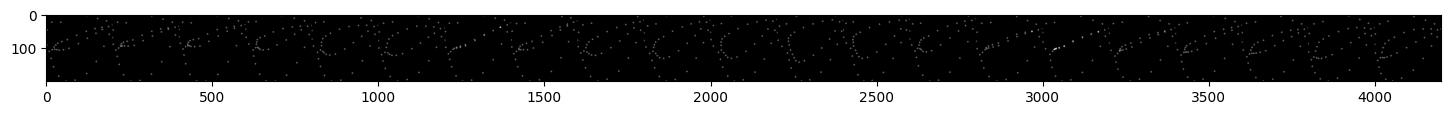

In [20]:
show_frames(frames=train_X_landmarks[0],landmark=True)
print(f"Class: {train_Y[0]}")

## Encode Labels

In [21]:
word_set = np.unique(train_Y)
word_set.sort()
word_set = [x.strip() for x in word_set]

temp_labels = np.concatenate((train_Y,test_Y,val_Y), axis=0)

class_count = {x:0 for x in word_set}
for x in temp_labels:
    class_count[x.strip()] += 1
print(class_count)

label_encoder = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=word_set,output_mode="one_hot"
)
num_words = len(label_encoder.get_vocabulary())
print(label_encoder.get_vocabulary())
print(label_encoder(label_encoder.get_vocabulary()))

{'ABOUT': 2194, 'AGAIN': 2198, 'AHEAD': 2198, 'ARRESTED': 2200, 'BELIEVE': 2200, 'BUSINESS': 2194, 'CHANCE': 2194, 'DESPITE': 2198, 'ELECTION': 2198, 'FAMILY': 2198, 'FIGURES': 2198, 'FOREIGN': 2200, 'FRANCE': 2200, 'GIVING': 2178, 'LATER': 2196, 'LEADERS': 2198, 'MIGHT': 2198, 'MINUTES': 2196, 'NEEDS': 2200, 'NOTHING': 2190, 'OFFICIALS': 2130, 'PAYING': 1822, 'POSSIBLE': 2198, 'POWERS': 2022, 'RIGHTS': 2190, 'SITUATION': 2200, 'STREET': 2198, 'TALKING': 2196, 'THIRD': 2200, 'THROUGH': 2198}
['ABOUT', 'AGAIN', 'AHEAD', 'ARRESTED', 'BELIEVE', 'BUSINESS', 'CHANCE', 'DESPITE', 'ELECTION', 'FAMILY', 'FIGURES', 'FOREIGN', 'FRANCE', 'GIVING', 'LATER', 'LEADERS', 'MIGHT', 'MINUTES', 'NEEDS', 'NOTHING', 'OFFICIALS', 'PAYING', 'POSSIBLE', 'POWERS', 'RIGHTS', 'SITUATION', 'STREET', 'TALKING', 'THIRD', 'THROUGH']


/mnt/iusers01/fse-ugpgt01/compsci01/h61781jp/.conda/envs/myenv/lib/python3.10/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0

In [22]:
def encode_labels(labels):
    data_Y = label_encoder(np.array([x.strip() for x in labels])).numpy()
    return data_Y

In [23]:
train_Y = encode_labels(labels=train_Y)
test_Y = encode_labels(labels=test_Y)
val_Y = encode_labels(labels=val_Y)

In [24]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224, 30)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528, 30)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528, 30)


# Export Data

In [25]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224, 30)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528, 30)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528, 30)


In [26]:
for i in range(5):
    filename = f"preprocessed/preprocessed_{(i + 1)}.mat"
    begin = (10500 * i)
    end = (10500 * (i + 1))
    
    savemat(file_name=os.path.join(proj_data_dir, filename), mdict={"train_data_frames":train_X_frames[begin:end], "train_data_keypoints":train_X_landmarks[begin:end], "train_labels": train_Y[begin:end],"test_data_frames":test_X_frames[begin:end], "test_data_keypoints":test_X_landmarks[begin:end], "test_labels": test_Y[begin:end],"val_data_frames":val_X_frames[begin:end], "val_data_keypoints":val_X_landmarks[begin:end], "val_labels": val_Y[begin:end]})